In [1]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setMaster('spark://master:7077').setAppName('Join')
sc = SparkContext(conf=conf)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/19 16:53:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
sc.setLogLevel('ERROR')
sc.version
sc.getConf().getAll()

[('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.app.startTime', '1668876817653'),
 ('spark.app.name', 'Join'),
 ('spark.master', 'spark://master:7077'),
 ('spark.driver.host', 'master'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.port', '36335'),
 ('spark.rdd.compr

In [3]:
from itertools import islice

fileRDD = (
    sc
#     .textFile('data/weblog_small.csv', 8)
    .textFile('data/weblog_very_large.csv', 8)
    .mapPartitionsWithIndex(
        lambda index, it: islice(it, 1, None) if index == 0 else it 
    )
    .map(lambda x: x.split(',')) # split each record with ',' seperator
    .map(lambda x: (x[0].split('/')[0], x[0].split('/')[1], x[1], x[2], x[3])) # split IP/UserID into two elements
)

1. Load the Web server log data into an RDD. Display the number of records in the
weblogs data. Filter the RDD to only contain successful requests (has response status
200) and count such numbers of records.

Each record has format [IP, Time, URL, Status]

In [4]:
successRequestRDD = (
    fileRDD
    .filter(lambda x: x[4] == '200')
)

In [5]:
print(f'Total number of successful requests: {successRequestRDD.count()}')

Total number of successful requests: 717486


2. Using the filtered RDD, create a Pair RDD with the UserID as the key, and the integer 1
as the value. The UserID is the first field in each line. Then, sum the values for each
UserID to get the total access times (#access) for each user

Map each record to (UserID, 1) and use reduceByKey to sum up all the record with the same UserID

In [6]:
accessTimeRDD = (
    successRequestRDD
    .map(lambda x: (x[1], 1))
    .reduceByKey(lambda a, b: a + b)
)

In [7]:
# Print top 20 users with highest number of access times
for _tuple in accessTimeRDD.takeOrdered(20, lambda x: -x[1]):
    print(_tuple)

('9774', 192)
('3776', 185)
('1191', 180)
('5793', 176)
('8899', 174)
('698', 170)
('734', 162)
('9138', 160)
('3067', 157)
('4451', 157)
('5451', 156)
('4718', 155)
('7385', 154)
('9548', 153)
('7978', 153)
('9733', 151)
('840', 151)
('6791', 151)
('6132', 151)
('1783', 150)


3. Calculate the histogram of user access. That is, determine how many users visited once,
twice, three times and so on. How many users visited the site once, 5 times, and 10
times? Use the full weblogs data filtered by successful requests only to produce this
result.

Create a similar rdd with section 2 with filtering the status code 200.
Map each record into (#access, 1) and reduce to sum up the values by #access

In [8]:
histogramRDD = (
    accessTimeRDD
    .map(lambda x: (x[1], 1))
    .reduceByKey(lambda a, b: a + b)
)

In [9]:
print(histogramRDD.top(20))


[(192, 1), (185, 1), (180, 1), (176, 1), (174, 1), (170, 1), (162, 1), (160, 1), (157, 2), (156, 1), (155, 1), (154, 1), (153, 2), (151, 4), (150, 3), (148, 4), (147, 3), (145, 4), (144, 3), (143, 2)]


4. Create an RDD based on the user data consisting of key/value-array pairs: (userid,
[ip/userid, time, url, status]).

Use map to select the corect fields

In [10]:
userDataRDD = (
    fileRDD
    .map(lambda x: (x[1], [x[0], x[2], x[3], x[4]]))
    .filter(lambda x: len(x[0]) > 0 and len(x[1]) == 4) # filter invalid data 
)

In [11]:
# Print top 10 results
for _tuple in userDataRDD.top(10):
    print(_tuple)

('99999', ['10.185.160.1', '05/24/2019:09:11:35', 'DELETE /compile.php HTTP/1.1', '302'])
('99999', ['10.171.240.1', '12/15/2021:07:59:51', 'POST /login.php HTTP/1.1', '200'])
('99999', ['10.105.123.1', '07/05/2019:10:41:39', 'UPDATE / HTTP/1.1', '304'])
('99999', ['10.104.130.1', '04/24/2020:08:50:11', 'GET /css/style.css HTTP/1.1', '200'])
('99998', ['10.174.16.1', '07/27/2014:03:24:50', 'UPDATE /home.php HTTP/1.1', '200'])
('99998', ['10.11.58.1', '07/21/2012:11:27:39', 'POST /js/vendor/modernizr-2.8.3.min.js HTTP/1.1', '200'])
('99997', ['10.151.180.1', '09/29/2014:02:29:25', 'GET / HTTP/1.1', '200'])
('99997', ['10.15.41.1', '04/11/2017:02:13:32', 'GET /img/ruet.png HTTP/1.1', '200'])
('99997', ['10.110.159.1', '03/29/2014:03:18:22', 'DELETE /css/font-awesome.min.css HTTP/1.1', '200'])
('99996', ['10.95.114.1', '02/07/2021:08:56:12', 'POST /js/vendor/jquery-1.12.0.min.js HTTP/1.1', '200'])


5. Join this Pair RDD with the set of UserID / #access pairs calculated in part (2).

Use join to perform inner join and map to select the fields

In [12]:
pairRDD = (
    userDataRDD
    .join(accessTimeRDD)
#     .map(lambda x: (x[0], x[1][1], x[1][0][0], x[1][0][-1]))
)

In [13]:
for _tuple in pairRDD.top(10):
    print(_tuple)

('99999', (['10.185.160.1', '05/24/2019:09:11:35', 'DELETE /compile.php HTTP/1.1', '302'], 2))
('99999', (['10.171.240.1', '12/15/2021:07:59:51', 'POST /login.php HTTP/1.1', '200'], 2))
('99999', (['10.105.123.1', '07/05/2019:10:41:39', 'UPDATE / HTTP/1.1', '304'], 2))
('99999', (['10.104.130.1', '04/24/2020:08:50:11', 'GET /css/style.css HTTP/1.1', '200'], 2))
('99998', (['10.174.16.1', '07/27/2014:03:24:50', 'UPDATE /home.php HTTP/1.1', '200'], 2))
('99998', (['10.11.58.1', '07/21/2012:11:27:39', 'POST /js/vendor/modernizr-2.8.3.min.js HTTP/1.1', '200'], 2))
('99997', (['10.151.180.1', '09/29/2014:02:29:25', 'GET / HTTP/1.1', '200'], 3))
('99997', (['10.15.41.1', '04/11/2017:02:13:32', 'GET /img/ruet.png HTTP/1.1', '200'], 3))
('99997', (['10.110.159.1', '03/29/2014:03:18:22', 'DELETE /css/font-awesome.min.css HTTP/1.1', '200'], 3))
('99996', (['10.95.114.1', '02/07/2021:08:56:12', 'POST /js/vendor/jquery-1.12.0.min.js HTTP/1.1', '200'], 3))


In [14]:
for _tuple in pairRDD.map(lambda x: (x[0], x[1][1], x[1][0][0], x[1][0][-1])).top(5):
    print(*_tuple)

99999 2 10.185.160.1 302
99999 2 10.171.240.1 200
99999 2 10.105.123.1 304
99999 2 10.104.130.1 200
99998 2 10.174.16.1 200


6.

a. Where is the Driver program executed?  
Driver program is executed in the master process

b. Where does the processing happen?  
The processing happen in slaves

c. Where is the result stored?  
The result is stored across the nodes (master and slaves)

d. How many stages and tasks were executed in total?  
There are total 9 stages and 96 tasks

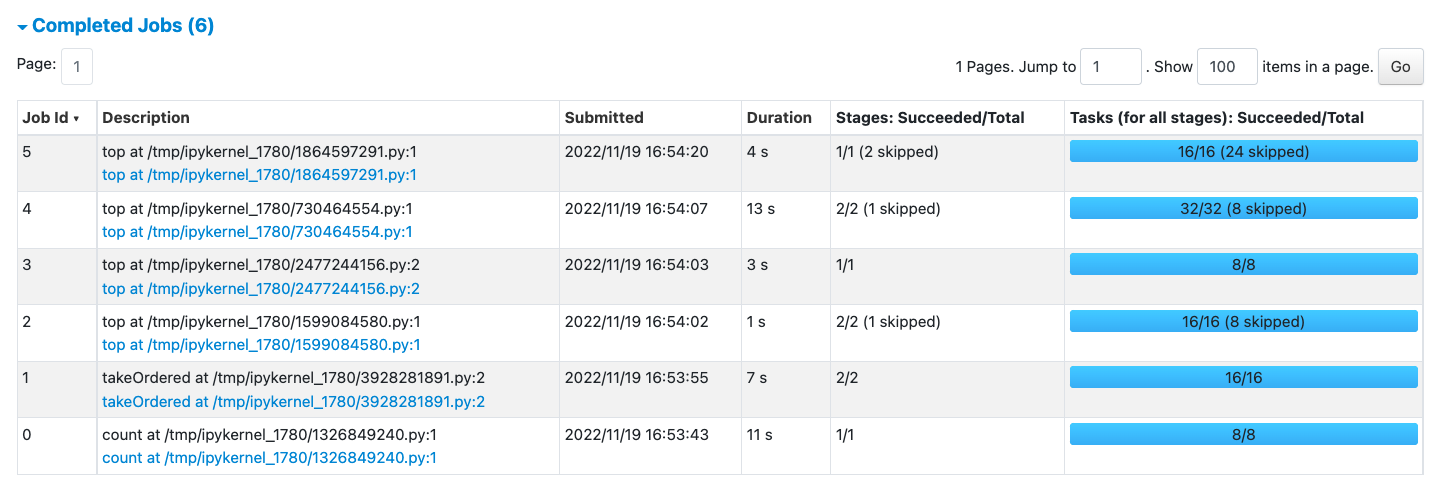